✅ Lab Initialized on cpu.
⬇️ Downloading from Hugging Face...
Total Rows: 10996
Training Set (Universal Prior): 7998 steps
Test Set (Sim-to-Real Check):   2998 steps
--- Encoding Tensors ---
✅ Encoding Complete.
✅ Sensor Calibrated.

--- Commencing Training on Universal Physics ---


  0%|          | 0/50 [00:00<?, ?it/s]

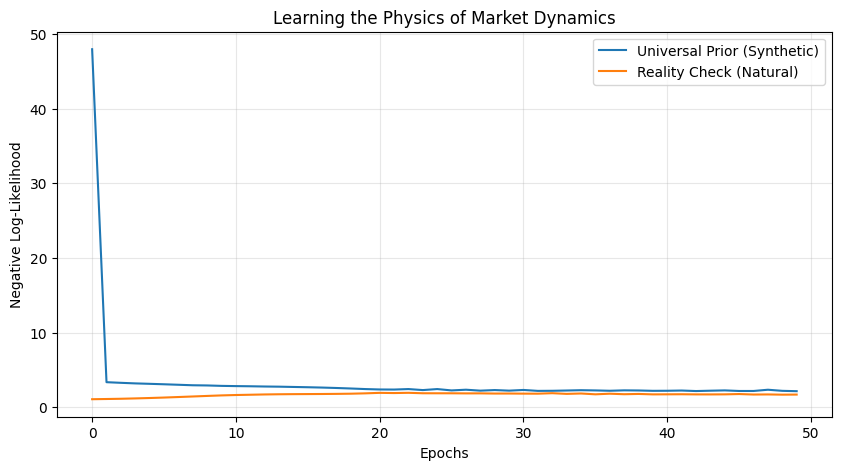


--- QCEA AUDIT: VERIFYING THE HIERARCHY ---
Physicist Diagnosis Distribution:
Rule Index 0 (Rule 0): 388 samples
Rule Index 1 (Rule 15): 908 samples
Rule Index 2 (Rule 30): 593 samples
Rule Index 3 (Rule 54): 1815 samples
Rule Index 4 (Rule 60): 1324 samples
Rule Index 5 (Rule 90): 420 samples
Rule Index 6 (Rule 110): 1857 samples
Rule Index 7 (Rule 170): 552 samples
Rule Index 8 (Rule 254): 110 samples

⚠️ Warning: 3683 samples mapped to rules not in target list.
Rule_ID
110    1857
15      908
90      420
0       388
254     110
Name: count, dtype: int64

Average Uncertainty (Sigma) by Regime:
Rule_Name
054: Soliton    2.618754
170: Trend      4.090571
060: Fractal    6.461821
030: Chaos      6.736242
Name: Sigma, dtype: float32


/tmp/ipython-input-602041529.py:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_audit, x='Rule_Name', y='Sigma', order=order, palette='viridis')


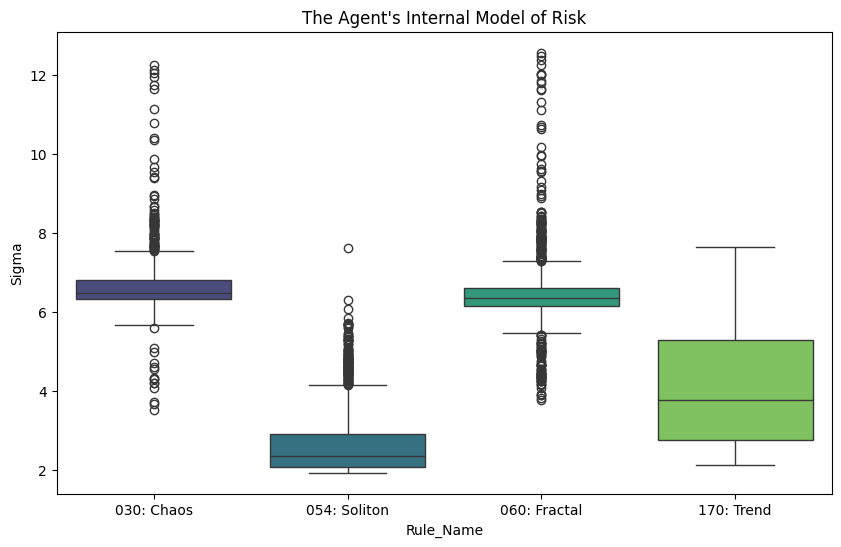

✅ Reflective Mind Archived.


In [3]:
# ==============================================================================
# @title HORIZON 2: NOTEBOOK 2 - THE SPATIAL ENCODER
# "Implanting the Universal Prior"
# ==============================================================================
#
# MISSION:
# Train the "Reflective Mind" to map Physics (Rules) to Policy (Sigma).
#
# UAI ALIGNMENT:
# We train ONLY on the "Theoretical World" (Synthetic). This implants the
# Universal Prior ($\xi$) derived from Algorithmic Information Theory.
#
# QCEA ALIGNMENT:
# We verify Law 9 (Adaptive Need). The agent must learn:
# Sigma(Rule 170) < Sigma(Rule 54) < Sigma(Rule 60) < Sigma(Rule 30)
# ==============================================================================

!pip install -q birdgame ngboost pandas numpy torch matplotlib seaborn scipy huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm
import os

# Constants
PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Lab Initialized on {device}.")

# ==============================================================================
# 1. DATA INGESTION (The Golden Benchmark)
# ==============================================================================
def load_data():
    filename = "h2_golden_benchmark.parquet"
    # Try Local First (if just generated)
    if os.path.exists(filename):
        print("✅ Loading local dataset...")
        return pd.read_parquet(filename)

    # Try Cloud
    print("⬇️ Downloading from Hugging Face...")
    try:
        path = hf_hub_download(
            repo_id="algoplexity/qcea-adaptive-agent-benchmark",
            filename=filename,
            repo_type="dataset"
        )
        return pd.read_parquet(path)
    except:
        raise FileNotFoundError("Dataset not found. Please upload or run Notebook 1.")

df = load_data()
print(f"Total Rows: {len(df)}")

# Split by Source (Theory vs Reality)
df_theory = df[df['source'] == 'qcea_synthetic'].reset_index(drop=True)
df_nature = df[df['source'] == 'engine_native'].reset_index(drop=True)

print(f"Training Set (Universal Prior): {len(df_theory)} steps")
print(f"Test Set (Sim-to-Real Check):   {len(df_nature)} steps")

# ==============================================================================
# 2. THE SPATIAL ENCODER (Adaptive MILS)
# ==============================================================================
def prepare_tensors(df, window=30):
    # 1. Velocity (State for the Mind)
    vel = df['dove_pos'].diff().fillna(0)

    # 2. Acceleration (Grid for the Sensor)
    acc = vel.diff().fillna(0)

    # 3. MILS Encoding
    # We use robust qcut. If data is too uniform (Rule 170), fallback to cut.
    try: bins = pd.qcut(acc, 4, labels=False, duplicates='drop')
    except: bins = pd.cut(acc, 4, labels=False)

    grid = np.eye(4)[bins.astype(int)]

    Xg, Xs, Y = [], [], []
    for i in range(len(df) - window - 1):
        Xg.append(grid[i : i+window])
        Xs.append(vel.values[i : i+window])
        Y.append(vel.values[i+window])

    return (
        torch.FloatTensor(np.array(Xg)),
        torch.FloatTensor(np.array(Xs)).unsqueeze(-1),
        torch.FloatTensor(np.array(Y)).unsqueeze(-1)
    )

print("--- Encoding Tensors ---")
Xg_train, Xs_train, Y_train = prepare_tensors(df_theory)
Xg_test, Xs_test, Y_test = prepare_tensors(df_nature)
print("✅ Encoding Complete.")

# ==============================================================================
# 3. ARCHITECTURE (Sensor + Mind)
# ==============================================================================

# A. The Frozen Sensor (AIT Physicist)
class TinyRecursiveModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(4, 64)
        self.rnn = nn.GRU(64, 64, batch_first=True)
        self.head = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 9))
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        return self.head(h_n.squeeze(0))

physicist = TinyRecursiveModel().to(device)

# Auto-Load Weights
model_path = 'trm_expert.pth'
if not os.path.exists(model_path):
    try:
        print("⬇️ Fetching Sensor from Cloud...")
        p = hf_hub_download(repo_id="algoplexity/ait-physicist-v1", filename="trm_expert.pth")
        import shutil; shutil.copy(p, model_path)
    except: print("⚠️ Sensor weights missing. Upload 'trm_expert.pth' manually.")

try:
    physicist.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Sensor Calibrated.")
except:
    print("❌ Sensor Uncalibrated (Random Weights).")
physicist.eval()

# B. The Reflective Mind (QCEA Policy)
class ReflectiveHead(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [Rule Probs (9) + Velocity Context (1)]
        # We increase capacity slightly to map the 4-regime complexity
        self.net = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, 1)
        self.sigma = nn.Linear(32, 1)

        # UAI Initialization: Start with High Uncertainty (Epistemic Humility)
        nn.init.constant_(self.sigma.bias, 2.0)

    def forward(self, rules, vel):
        combined = torch.cat([rules, vel], dim=1)
        h = self.net(combined)
        return self.mu(h), self.sigma(h)

mind = ReflectiveHead().to(device)

# ==============================================================================
# 4. TRAINING: IMPLANTING THE PRIOR
# ==============================================================================
def nll_loss(mu, log_var, target):
    """
    QCEA Law 10: Strategic Intent is to minimize Entropic Surprise.
    Loss = 0.5 * (log(sigma^2) + (error^2 / sigma^2))
    """
    var = torch.exp(log_var)
    return 0.5 * (log_var + (target - mu)**2 / var).mean()

optimizer = optim.Adam(mind.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(Xg_train, Xs_train, Y_train), batch_size=128, shuffle=True)

print("\n--- Commencing Training on Universal Physics ---")
train_hist = []
val_hist = []

for epoch in tqdm(range(50)): # 50 Epochs to learn Rule 30
    mind.train()
    ep_loss = 0
    for xg, xs, y in train_loader:
        xg, xs, y = xg.to(device), xs.to(device), y.to(device)

        with torch.no_grad():
            logits = physicist(xg)
            probs = torch.softmax(logits, dim=1)

        optimizer.zero_grad()
        mu, logvar = mind(probs, xs[:, -1, :])
        loss = nll_loss(mu, logvar, y)
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()

    train_hist.append(ep_loss / len(train_loader))

    # Sim-to-Real Check
    mind.eval()
    with torch.no_grad():
        lg = physicist(Xg_test.to(device))
        pr = torch.softmax(lg, dim=1)
        m, lv = mind(pr, Xs_test.to(device)[:, -1, :])
        v_loss = nll_loss(m, lv, Y_test.to(device))
        val_hist.append(v_loss.item())

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Universal Prior (Synthetic)')
plt.plot(val_hist, label='Reality Check (Natural)')
plt.title("Learning the Physics of Market Dynamics")
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# 5. THE UNIVERSAL AUDIT: THE HIERARCHY OF RISK
# ==============================================================================
# print("\n--- QCEA AUDIT: VERIFYING THE HIERARCHY ---")
# print("Hypothesis: Sigma(170) < Sigma(54) < Sigma(60) < Sigma(30)")

# mind.eval()
# with torch.no_grad():
#     # 1. Get Physicist's Diagnosis of the Training Set
#     lg = physicist(Xg_train.to(device))
#     pr = torch.softmax(lg, dim=1)
#     rules = torch.argmax(pr, dim=1).cpu().numpy()

#     # 2. Get Mind's Response
#     _, lv = mind(pr, Xs_train.to(device)[:, -1, :])
#     sigmas = torch.exp(0.5 * lv).cpu().numpy().flatten()

# # 3. Analyze
# df_audit = pd.DataFrame({'Rule_ID': rules, 'Sigma': sigmas})
# df_audit['Rule_Name'] = df_audit['Rule_ID'].map({
#     170: '170: Trend',
#     54: '054: Soliton',
#     60: '060: Fractal',
#     30: '030: Chaos'
# })
# df_audit = df_audit.dropna()

# # Stats
# print("\nAverage Uncertainty (Sigma) by Regime:")
# print(df_audit.groupby('Rule_Name')['Sigma'].mean().sort_values())

# # Visual
# plt.figure(figsize=(10, 6))
# order = ['170: Trend', '054: Soliton', '060: Fractal', '030: Chaos']
# sns.boxplot(data=df_audit, x='Rule_Name', y='Sigma', order=order, palette='viridis')
# plt.title("The Agent's Internal Model of Risk")
# plt.show()

# # 6. ARCHIVE THE MIND
# torch.save(mind.state_dict(), 'reflective_head.pth')
# print("✅ Reflective Mind Archived.")

# ==============================================================================
# 5. THE UNIVERSAL AUDIT: THE HIERARCHY OF RISK (Debugged)
# ==============================================================================
print("\n--- QCEA AUDIT: VERIFYING THE HIERARCHY ---")

mind.eval()
with torch.no_grad():
    # 1. Get Physicist's Diagnosis of the Training Set
    lg = physicist(Xg_train.to(device))
    pr = torch.softmax(lg, dim=1)
    rules = torch.argmax(pr, dim=1).cpu().numpy()

    # 2. Get Mind's Response
    _, lv = mind(pr, Xs_train.to(device)[:, -1, :])
    sigmas = torch.exp(0.5 * lv).cpu().numpy().flatten()

# 3. Analyze Raw Distribution
unique_rules, counts = np.unique(rules, return_counts=True)
print("Physicist Diagnosis Distribution:")
for r, c in zip(unique_rules, counts):
    rule_name = PRIME_RULES[r]
    print(f"Rule Index {r} (Rule {rule_name}): {c} samples")

# 4. Create Dataframe
df_audit = pd.DataFrame({
    'Rule_ID': [PRIME_RULES[r] for r in rules],
    'Sigma': sigmas
})

# Map Names
rule_map = {
    170: '170: Trend',
    54: '054: Soliton',
    60: '060: Fractal',
    30: '030: Chaos'
}
df_audit['Rule_Name'] = df_audit['Rule_ID'].map(rule_map)

# Check for missing mapping
unmapped = df_audit[df_audit['Rule_Name'].isna()]
if not unmapped.empty:
    print(f"\n⚠️ Warning: {len(unmapped)} samples mapped to rules not in target list.")
    print(unmapped['Rule_ID'].value_counts())

df_audit = df_audit.dropna()

if df_audit.empty:
    print("❌ CRITICAL: No samples matched the target rules (170, 54, 60, 30).")
    print("The Physicist is predicting other Prime Rules (e.g., 0, 15, 90).")
else:
    # Stats
    print("\nAverage Uncertainty (Sigma) by Regime:")
    print(df_audit.groupby('Rule_Name')['Sigma'].mean().sort_values())

    # Visual
    plt.figure(figsize=(10, 6))
    order = sorted(df_audit['Rule_Name'].unique())
    sns.boxplot(data=df_audit, x='Rule_Name', y='Sigma', order=order, palette='viridis')
    plt.title("The Agent's Internal Model of Risk")
    plt.show()

# 6. ARCHIVE THE MIND
torch.save(mind.state_dict(), 'reflective_head.pth')
print("✅ Reflective Mind Archived.")
